In [1]:
import heapq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import simpy
import time
import warnings

In [2]:
def generate_service_time():
        # Determine service time based on a mixture of two exponentials
        if random.random() <= 0.75:
            return random.expovariate(1)  # 75% with average service time 1
        else:
            return random.expovariate(0.2)  # 25% with average service time 5
        
#note: mu = 0.75*1+ 0.25*0.2 = 0.8        

In [10]:
i=0
while i < 5: 
    i +=1
    j = generate_service_time()
    print(j)

1.1776513036182992
0.6142944616165213
0.8045101987313601
5.435190375076706
0.2666956692721431


In [3]:
def customer(env, customer, servers, mu, que_arr):
    """This generator function models the behavior of a customer in the queue."""
    time_of_arrival = env.now
    que_arr.append((env.now, len(servers.queue)))
    with servers.request() as req:    
        #print(env.now, 'customer {} arrives'.format(customer))
        yield req
        time_of_handling = generate_service_time()
        #print(env.now, 'customer {} is being served'.format(customer))
        yield env.timeout(time_of_handling)
        waiting_time = env.now
        #print(env.now, 'customer {} departs'.format(customer))
        total_waiting_time.append((env.now, waiting_time-time_of_arrival))

In [4]:
def source(env, n, rho, mu, servers, que_arr):
    """Source generates customers randomly based on exponential distribution"""
    i = 0
    while True:
        i += 1
        c = customer(env, i, servers, mu, que_arr)
        env.process(c)
        interarrival_time = random.expovariate((n*rho)*mu) # lambda = rho * n * mu 
        yield env.timeout(interarrival_time)          

In [5]:
# Setup and start the simulation
def sim_run(n,rho,mu,sim_duration):
    env = simpy.Environment()
    # Start processes and run
    que_arr =[]
    servers = simpy.Resource(env, capacity=n)
    env.process(source(env, n, rho, mu, servers, que_arr))
    env.run(until=sim_duration)
    return total_waiting_time, que_arr

In [6]:
total_waiting_time = []

mean_queue_lengths = pd.DataFrame()
mean_std_ci_queue_lengths = pd.DataFrame()
mean_std_ci_waiting_time = pd.DataFrame()
waiting_time_general_stat = pd.DataFrame()

rho_vals = [0.85,0.9,0.95,0.99] # arrival rate (λ) / n * mu
serv = [1, 2, 4] # number of servers
sim_time = 20000
mu = 0.8      #note: mu = 0.75*1+ 0.25*0.2 = 0.8  
z_score = 1.96
simulations = 10

all_results = []
second_data_que = []
mean_vaiting = []
all_results_mean = []

In [7]:
# The loops to go through numb. of servers and p value
for server in serv:
    for p_value in rho_vals:
        # defne arrays and vars reused for each params.
        
        second_data_que = []
        mean_vaiting = []
        mean_waiting_data_for_statistics = []
        std_waiting_data_for_statistics = []
        customers_srvd_stat = []
        queue_stat = []
        
        maxim = -np.inf
        minim = np.inf
        maxim_que = -np.inf
        minim_que = np.inf
        maxim_customers_served = -np.inf
        minim_customers_served = np.inf
        
        # run simulations
        for run in range(simulations):
            #run and extract data from simulation 
            waiting_data, queue_data = sim_run(server,p_value,mu,sim_time)
            
            #calculate everything for dataframe that will calculate overall satatistics for n simulations
            f = lambda a: a[1]
            waiting_data_true = list(map(f, waiting_data))
            queue_data_true = list(map(f, queue_data))
            
            mean_queue_cur_sim = np.mean(queue_data_true)
            mean_waiting_cur_sim = np.mean(waiting_data_true)
            
            max_waiting = np.max(waiting_data_true)
            maxim = max(max_waiting, maxim)
            
            min_waiting = np.min(waiting_data_true)
            minim = min(min_waiting, minim)
            
            max_que = np.max(queue_data_true)
            maxim_que = max(max_que, maxim_que)
            
            min_que = np.min(queue_data_true)
            minim_que = min(min_que, minim_que)
            
            customer_served = len(waiting_data_true)
            maxim_customers_served = max(customer_served, maxim_customers_served)
            minim_customers_served = min(customer_served, minim_customers_served)
            std_within_sim_waiting = np.std(waiting_data_true)
            
            mean_waiting_data_for_statistics.append(mean_waiting_cur_sim)
            std_waiting_data_for_statistics.append(std_within_sim_waiting)
            queue_stat.append(mean_queue_cur_sim)
            customers_srvd_stat.append(customer_served)
            
            # create dataframes for interday statistics for n sims
            df_queue = pd.DataFrame(queue_data, columns=['Time', 'Queue_Length'])
            df_queue['Time'] = df_queue['Time'].round().astype(int) // 100
            df_second_mean = df_queue.groupby('Time').mean()
            second_data_que.append(df_second_mean)
            df_waiting = pd.DataFrame(waiting_data, columns=['Time', 'Waiting_time'])
            df_waiting['Time'] = df_waiting['Time'].round().astype(int) // 100
            df_waiting_mean = df_waiting.groupby('Time').mean()
            mean_vaiting.append(df_waiting_mean)
            
        # calculations related to daily dataframes. 
        # two dataframes with mean value for every 100 days 
        for second in range(0, int(sim_time/100)):
            interval_data = [pd.Series(df.loc[second]['Queue_Length']) if second in df.index else pd.Series([0]) for df in second_data_que]
            concatenated_data = pd.concat(interval_data, ignore_index=True)
            mean_length = concatenated_data.mean()
            std_dev = concatenated_data.std()
            margin_of_error = z_score * (std_dev / np.sqrt(len(concatenated_data)))
            lower_bound = mean_length - margin_of_error
            upper_bound = mean_length + margin_of_error
            mean_std_ci_queue_lengths = mean_std_ci_queue_lengths._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Queue_Length': mean_length,
                'Std_Dev_Queue_Length': std_dev,
                'CI_Lower_Bound': lower_bound,
                'CI_Upper_Bound': upper_bound
            }, ignore_index=True)
            interval_data_waiting = [pd.Series(df.loc[second]['Waiting_time']) if second in df.index else pd.Series() for df in mean_vaiting]
            concatenated_data_waiting = pd.concat(interval_data_waiting, ignore_index=True)
            mean_length_waiting = concatenated_data_waiting.mean()
            std_dev_waiting = concatenated_data_waiting.std()
            confidence_waiting_time = z_score * (std_dev_waiting / np.sqrt(len(concatenated_data_waiting)))
            lower_bound_waiting = mean_length_waiting - confidence_waiting_time
            upper_bound_waiting = mean_length_waiting + confidence_waiting_time
            mean_std_ci_waiting_time = mean_std_ci_waiting_time._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Waiting_time': mean_length_waiting,
                'Std_Dev_Waiting_time': std_dev_waiting,
                'CI_Lower_Bound': lower_bound_waiting,
                'CI_Upper_Bound': upper_bound_waiting
            }, ignore_index=True)
            
        # calculations for overall statistics over 100 simulations
        whole_sim_mean = np.mean(mean_waiting_data_for_statistics) 
        whole_sim_within_std = np.mean(std_waiting_data_for_statistics)
        std_whole_sim = np.std(mean_waiting_data_for_statistics)  
        std_fr_std_whole_sim = np.std(std_waiting_data_for_statistics)  
        confidence_waiting_time_whole = z_score * (std_whole_sim / np.sqrt(len(mean_waiting_data_for_statistics)))
        lower_bound_waiting_whole = whole_sim_mean - confidence_waiting_time_whole
        upper_bound_waiting_whole = whole_sim_mean + confidence_waiting_time_whole   
        confidence_waiting_std_within = z_score * (std_fr_std_whole_sim / np.sqrt(len(std_waiting_data_for_statistics)))
        lower_bound_waiting_std_within = whole_sim_within_std - confidence_waiting_std_within
        upper_bound_waiting_std_within = whole_sim_within_std + confidence_waiting_std_within 
        customers_served_mean = np.mean(customers_srvd_stat)
        customers_served_std = np.std(customers_srvd_stat)
        confidence_customers_served = z_score * (customers_served_std / np.sqrt(len(customers_srvd_stat)))
        lower_bound_customers_served = customers_served_mean - confidence_customers_served
        upper_bound_customers_served = customers_served_mean + confidence_customers_served 
        mean_que = np.mean(queue_stat)
        std_que = np.mean(queue_stat)
        confidence_que = z_score * (std_que / np.sqrt(len(queue_stat)))
        lower_bound_que = mean_que - confidence_que
        upper_bound_que = mean_que + confidence_que 
        waiting_time_general_stat = waiting_time_general_stat._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Mean_Waiting_time': whole_sim_mean,
                'Mean_Within_Std_of_Waiting_time': whole_sim_within_std,
                'Customers_Served': customers_served_mean,
                'Mean_queue': mean_que,
                'Std_within_Waiting_time': std_fr_std_whole_sim,
                'Std_Dev_Waiting_time': std_whole_sim,
                'Std_Dev_Customers_served': customers_served_std,
                'Std_Dev_Queue': std_que,
                'CI_Lower_Bound_Mean': lower_bound_waiting_whole,
                'CI_Upper_Bound_Mean': upper_bound_waiting_whole,
                'CI_Lower_Bound_Std': lower_bound_waiting_std_within,
                'CI_Upper_Bound_Std': upper_bound_waiting_std_within, 
                'CI_Lower_Bound_Customers_Served': lower_bound_customers_served,
                'CI_Upper_Bound_Customers_Served': upper_bound_customers_served, 
                'CI_Lower_Bound_Queue': lower_bound_que,
                'CI_Upper_Bound_Queue': upper_bound_que, 
                'Min_waiting_time': minim,
                'Max_waiting_time': maxim,
                'Min_queue': minim_que,
                'Max_queue': maxim_que,
                'Min_customers_served': minim_customers_served,
                'Max_customers_served': maxim_customers_served
                }, ignore_index=True)
 

In [ ]:
#print(f"Total customers served: {len(que_arr)}")
#average_waiting_time = sum(que_arr) / len(que_arr)
#print(f"Average waiting time: {average_waiting_time}")

In [8]:
mean_std_ci_queue_lengths_df = pd.DataFrame(mean_std_ci_queue_lengths )
mean_std_ci_waiting_time_df = pd.DataFrame(mean_std_ci_waiting_time)
waiting_time_general_stat_df = pd.DataFrame(waiting_time_general_stat)

/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2891521664.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2891521664.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2891521664.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2891521664.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2891521664.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_va

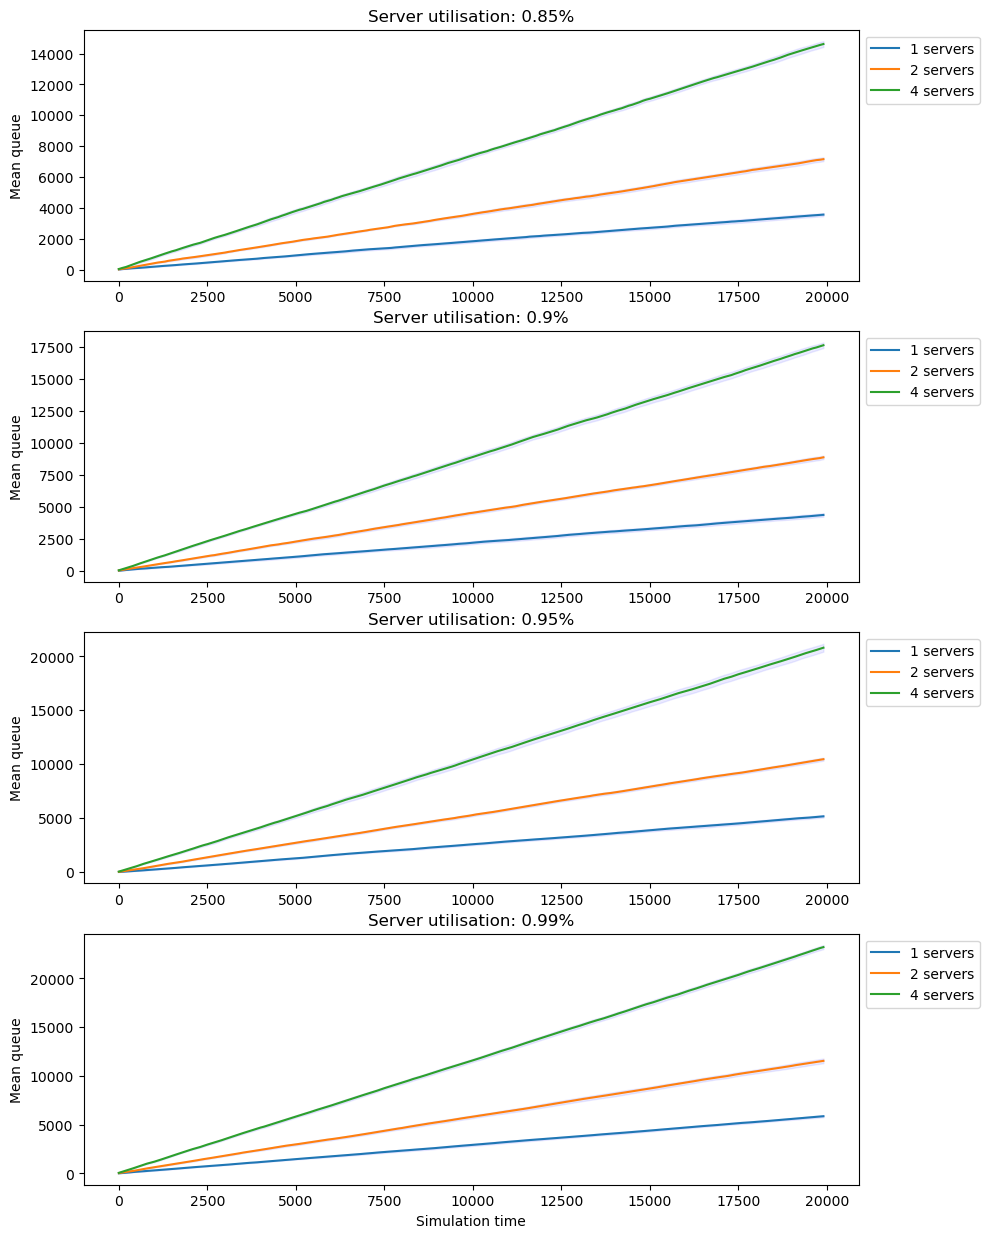

In [9]:
def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Queue_Length"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u


serv = [1, 2, 4]
p = [0.85, 0.9, 0.95, 0.99]


ma = []
for x in range(0, 20000, 100):
    ma.append(x)

fig, axs = plt.subplots(4, 1, figsize=(10, 15))  

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.85)
    axs[0].plot(ma, y, label=f"{pp} servers")
    axs[0].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[0].set_ylabel("Mean queue length")
    axs[0].set_title("Server utilisation: 0.85%")
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.9)
    axs[1].plot(ma, y, label=f"{pp} servers")
    axs[1].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[1].set_ylabel("Mean queue length")
    axs[1].set_title("Server utilisation: 0.9%")
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.95)
    axs[2].plot(ma, y, label=f"{pp} servers")
    axs[2].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[2].set_ylabel("Mean queue lenght")
    axs[2].set_title("Server utilisation: 0.95%")
    axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))


for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, 0.99)
    axs[3].plot(ma, y, label=f"{pp} servers")
    axs[3].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[3].set_ylabel("Mean queue length")
    axs[3].set_xlabel("Simulation time")
    axs[3].set_title("Server utilisation: 0.99%")
    axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))



In [11]:
mean_std_ci_queue_lengths

,Server_Count,P_Value,Time_Second,Mean_Queue_Length,Std_Dev_Queue_Length,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,12.704026,3.524253,10.519671,14.888380
1,1.0,0.85,200.0,35.399771,10.961459,28.605788,42.193754
2,1.0,0.85,300.0,50.960375,21.094458,37.885895,64.034855
3,1.0,0.85,400.0,69.628033,21.752958,56.145410,83.110656
4,1.0,0.85,500.0,87.584491,21.767202,74.093040,101.075943
...,...,...,...,...,...,...,...
2395,4.0,0.99,19600.0,22744.890013,322.978675,22544.705756,22945.074270
2396,4.0,0.99,19700.0,22863.071126,321.310145,22663.921034,23062.221217
2397,4.0,0.99,19800.0,22984.413227,320.415994,22785.817336,23183.009117
2398,4.0,0.99,19900.0,23103.145976,334.649352,22895.728159,23310.563794


/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2657292274.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2657292274.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2657292274.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2657292274.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_value]
/var/folders/zq/_9pxghts129f4c021xj0nv2c0000gn/T/ipykernel_92605/2657292274.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filted_set_f2 = filted_set[mask_p_va

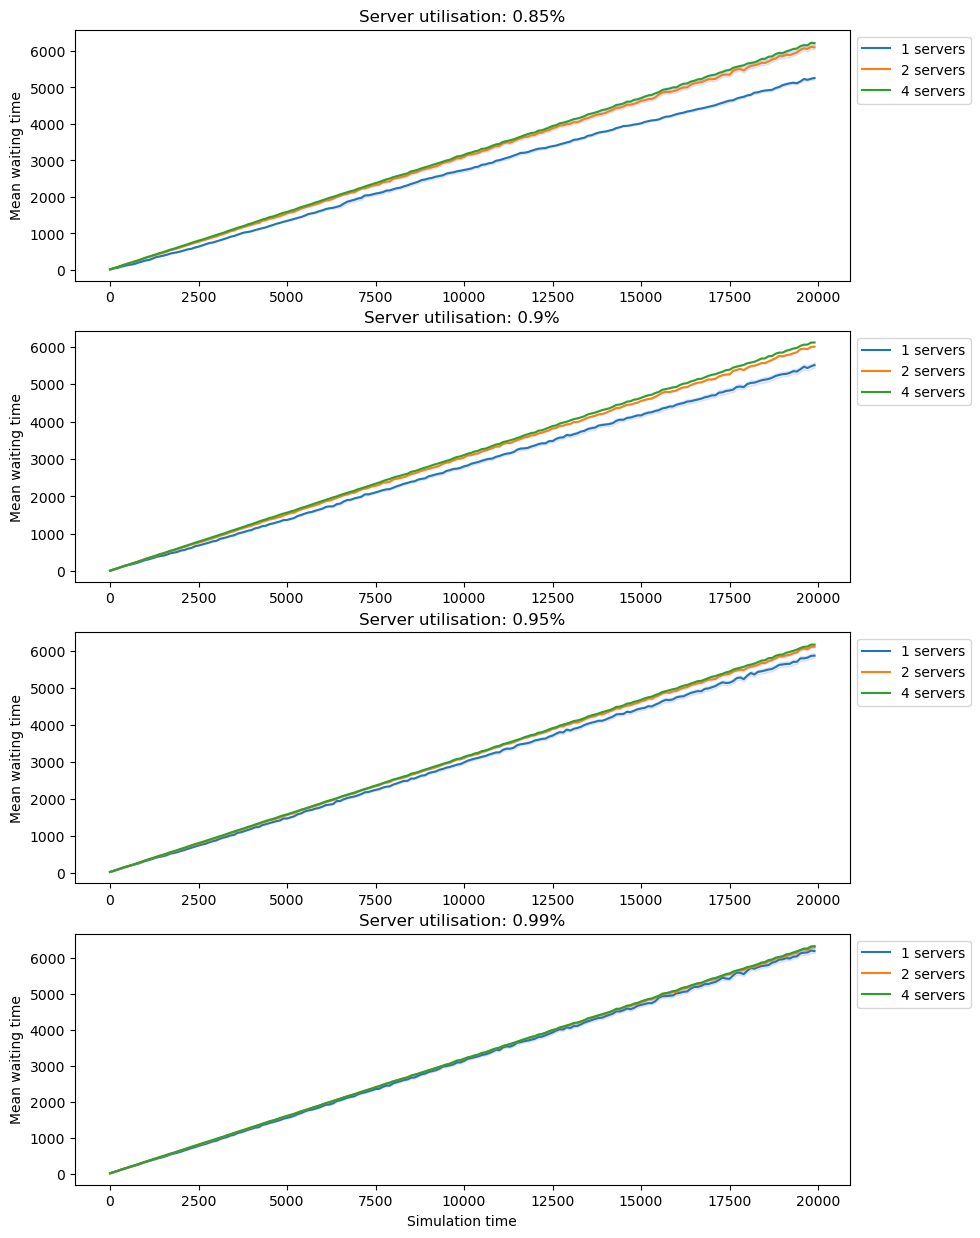

In [12]:
def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Waiting_time"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u


serv = [1, 2, 4]
p = [0.85, 0.9, 0.95, 0.99]


ma = []
for x in range(0, 20000, 100):
    ma.append(x)

fig, axs = plt.subplots(4, 1, figsize=(10, 15)) 
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.85)
    axs[0].plot(ma, y, label=f"{pp} servers")
    axs[0].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[0].set_ylabel("Mean waiting time")
    #axs[i].legend()
    axs[0].set_title("Server utilisation: 0.85%")
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.9)
    axs[1].plot(ma, y, label=f"{pp} servers")
    axs[1].set_title("Server utilisation: 0.9%")
    axs[1].set_ylabel("Mean waiting time")
    axs[1].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.95)
    axs[2].plot(ma, y, label=f"{pp} servers")
    axs[2].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[2].set_ylabel("Mean waiting time")
    axs[2].set_title("Server utilisation: 0.95%")
    axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.99)
    axs[3].plot(ma, y, label=f"{pp} servers")
    axs[3].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[3].set_ylabel("Mean waiting time")
    axs[3].set_xlabel("Simulation time")
    axs[3].set_title("Server utilisation: 0.99%")
    axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
mean_std_ci_waiting_time

In [ ]:
waiting_time_general_stat.columns

In [ ]:
mak = mean_std_ci_waiting_time["Server_Count"] == 1
mak2 = mean_std_ci_waiting_time["P_Value"] == 0.99
filtered_dataset = mean_std_ci_waiting_time[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Waiting_time"]
ma = []
for x in range(0, 20000, 100):
    ma.append(x)
plt.plot(ma, filtered_datasetos)
mak = mean_std_ci_waiting_time["Server_Count"] == 2
mak2 = mean_std_ci_waiting_time["P_Value"] == 0.99
filtered_dataset = mean_std_ci_waiting_time[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Waiting_time"].rolling(window=1).mean()
ma = []
for x in range(0, 20000, 100):
    ma.append(x)
plt.plot(ma, filtered_datasetos)
mak = mean_std_ci_waiting_time["Server_Count"] == 4
mak2 = mean_std_ci_waiting_time["P_Value"] == 0.99
filtered_dataset = mean_std_ci_waiting_time[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Waiting_time"].rolling(window=1).mean()
ma = []
for x in range(0, 20000, 100):
    ma.append(x)
plt.plot(ma, filtered_datasetos)

In [ ]:
mean_std_ci_queue_lengths

In [ ]:
def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Waiting_time"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u


serv = [1, 2, 4]
p = [0.85, 0.9, 0.95, 0.99]


ma = []
for x in range(0, 20000, 100):
    ma.append(x)

fig, axs = plt.subplots(4, 1, figsize=(10, 15)) 
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.85)
    axs[0].plot(ma, y, label=f"{pp} servers")
    axs[0].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[0].set_ylabel("Mean waiting time")
    #axs[i].legend()
    axs[0].set_title("Server utilisation: 0.85%")
    axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.9)
    axs[1].plot(ma, y, label=f"{pp} servers")
    axs[1].set_title("Server utilisation: 0.9%")
    axs[1].set_ylabel("Mean waiting time")
    axs[1].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))
for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.95)
    axs[2].plot(ma, y, label=f"{pp} servers")
    axs[2].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[2].set_ylabel("Mean waiting time")
    axs[2].set_title("Server utilisation: 0.95%")
    axs[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

for pp in serv:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, 0.99)
    axs[3].plot(ma, y, label=f"{pp} servers")
    axs[3].fill_between(ma, low, up, color='b', alpha=0.08)
    axs[3].set_ylabel("Mean waiting time")
    axs[3].set_xlabel("Simulation time")
    axs[3].set_title("Server utilisation: 0.99%")
    axs[3].legend(loc='upper left', bbox_to_anchor=(1, 1))


In [ ]:
def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Waiting_time"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u


serv = [1, 2, 4]
p = [0.85, 0.9, 0.95, 0.99]


ma = []
for x in range(0, 20000, 100):
    ma.append(x)

fig, axs = plt.subplots(3, 1, figsize=(10, 15)) 

for pp in p:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, 1, pp)
    axs[0].plot(ma, y)
    axs[0].fill_between(ma, low, up, color='b', alpha=0.1)

for pp in p:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, 2, pp)
    axs[1].plot(ma, y)
    axs[1].fill_between(ma, low, up, color='b', alpha=0.1)

for pp in p:
    y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, 4, pp)
    axs[2].plot(ma, y)
    axs[2].fill_between(ma, low, up, color='b', alpha=0.1)


In [ ]:
mean_std_ci_waiting_time

In [ ]:
mak = mean_std_ci_waiting_time["Server_Count"] == 4
mak2 = mean_std_ci_waiting_time["P_Value"] == 0.99
filtered_dataset = mean_std_ci_waiting_time[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Waiting_time"]
filtered_datasetos = np.array(filtered_datasetos)
ma = []
for x in range(0, 20000, 100):
    ma.append(x)
print(ma)
x = np.linspace(0, 19999, 20000)
plt.plot(ma, filtered_datasetos)
mak = mean_std_ci_waiting_time["Server_Count"] == 2
mak2 = mean_std_ci_waiting_time["P_Value"] == 0.99
filtered_dataset = mean_std_ci_waiting_time[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Waiting_time"]
filtered_datasetos = np.array(filtered_datasetos)
ma = []
for x in range(0, 20000, 100):
    ma.append(x)
print(ma)
x = np.linspace(0, 19999, 20000)
plt.plot(ma, filtered_datasetos)
mak = mean_std_ci_waiting_time["Server_Count"] == 1
mak2 = mean_std_ci_waiting_time["P_Value"] == 0.99
filtered_dataset = mean_std_ci_waiting_time[mak]
filtered_dataseto = filtered_dataset[mak2]
filtered_datasetos = filtered_dataseto["Mean_Waiting_time"]
filtered_datasetos = np.array(filtered_datasetos)
ma = []
for x in range(0, 20000, 100):
    ma.append(x)
print(ma)
x = np.linspace(0, 19999, 20000)
plt.plot(ma, filtered_datasetos)

In [ ]:
waiting_time_general_stat.columns

In [ ]:
def plot_heatmap(df, col_name, ax, rn):
    heatmap_data = df.pivot_table(index='Server_Count', columns='P_Value', values=col_name, aggfunc=np.mean)
    sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".2f", ax=ax)
    ax.set_xlabel("P Value")
    ax.set_ylabel("Server Count")
    ax.set_title(f"Heatmap for {rn}")   

fig, axs = plt.subplots(3, 2, figsize=(10, 15)) 

of_int = ["Mean_queue", "Customers_Served", "Mean_Waiting_time", "Mean_Within_Std_of_Waiting_time", "Max_waiting_time", "Max_queue"]
of_int_norm = ["Mean Queue", "Customers Served", "Mean Waiting Time", "Mean Std. for waiting time in each sim.", "Max. Waiting Time", "Max. Queue"]

for i, col_name in enumerate(of_int):
    ax = axs[i//2, i%2]  # Determine the row and column index
    plot_heatmap(waiting_time_general_stat, col_name, ax,of_int_norm[i])

plt.tight_layout()  
plt.show()  
